In [149]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import statsmodels.api as sm
from scipy.special import gamma, loggamma, factorial
import scipy.stats
from scipy.interpolate import interp1d
from matplotlib.ticker import AutoMinorLocator 
from matplotlib import rc, font_manager
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors
from mycolorpy import colorlist as mcp
from matplotlib import legend_handler
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import collections
import matplotlib
import shapely.geometry
import shapely.ops 
from geopy.geocoders import Nominatim
import geopandas as gpd
import mapclassify
import jenkspy
import contextily as cx
import os
import rioxarray as rx
import pyreadr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import plots
import seaborn as sns
from prophet import Prophet
import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
wd = os.path.dirname(os.getcwd())

In [3]:
country = "ARG"

if country == "ARG":
    country_full = "argentina"
elif country == "CHL":
    country_full = "chile"
elif country == "COL":
    country_full = "colombia"
elif country == "MEX":
    country_full = "mexico"

In [28]:
gdf = gpd.read_file(wd + '/data/outputs/' + country + '/gdf_' + country + '_admin_fua_rdi.gpkg').to_crs('epsg:4326')



In [29]:
len(gdf)

163

In [45]:
evo_admins_crisis = []
evo_admins_baseline = []
evo_admins_perchange = []

months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
years = ['2020', '2021', '2022']

gdf_admin_mov = gdf

for year in years:
    for month in months:
        print(month, year)
        try:
            df_mov = pyreadr.read_r('/Volumes/RECAST/data/outputs/' + country_full + '/movements/' + str(year) + '_' + str(month) + '_mov.rds')
            df_mov = df_mov[None]
            df_mov = df_mov[df_mov['length_km'] > 0].reset_index(drop=True)
            df_mov = df_mov[df_mov['length_km'] < 70].reset_index(drop=True)
            df_mov['geometry'] = df_mov['geometry'].apply(shapely.wkt.loads)
            gdf_mov = gpd.GeoDataFrame(df_mov, crs='epsg:4326')
        except:
            print('no')
            continue
            
        gdf_mov_join = gdf_mov
        gdf_admin_mov_join = gdf.sjoin(gdf_mov_join, how="left", predicate='intersects')

        gdf_admin_mov_join['index'] = gdf_admin_mov_join.index
        gdf_admin_mov_join = gdf_admin_mov_join.drop(['date_time', 'date_time2', 'geometry'], axis=1)
        
        gdf_group = gdf_admin_mov_join.groupby(['index']).sum().reset_index(drop=True)

        gdf_admin_mov['n_crisis_' + str(month) + '_' + str(year)] = gdf_group['n_crisis']
        gdf_admin_mov['n_baseline_' + str(month) + '_' + str(year)] = gdf_group['n_baseline']
        gdf_admin_mov['n_perchange_' + str(month) + '_' + str(year)] = (gdf_group['n_crisis']-gdf_group['n_baseline'])/gdf_group['n_baseline']*100

for year in years:
    for month in months:  
        try:
            gdf_admin_mov = gdf_admin_mov[gdf_admin_mov['n_baseline_' + str(month) + '_' + str(year)] != 0].reset_index(drop=True)
        except:
            continue
            
for year in years:
    for month in months:  
        try: 
            gdf_admin_mov['z_score_crisis_' + str(month) + '_' + str(year)] = np.abs(scipy.stats.zscore(gdf_admin_mov['n_crisis_' + str(month) + '_' + str(year)]))
            gdf_admin_mov['z_score_baseline_' + str(month) + '_' + str(year)] = np.abs(scipy.stats.zscore(gdf_admin_mov['n_baseline_' + str(month) + '_' + str(year)]))
            gdf_admin_mov['z_score_perchange_' + str(month) + '_' + str(year)] = np.abs(scipy.stats.zscore(gdf_admin_mov['n_perchange_' + str(month) + '_' + str(year)]))
        except:
            continue
            
gdf_admin_mov.to_file(wd + '/data/outputs/' + country + '/gdf_' + country + '_admin_rdi_mov_evo.gpkg')
            

01 2020
no
02 2020
no
03 2020
no
04 2020
05 2020
06 2020
07 2020
08 2020
09 2020
10 2020
11 2020
12 2020
01 2021
02 2021
03 2021
04 2021
05 2021
06 2021
07 2021
08 2021
09 2021
10 2021
11 2021
12 2021
01 2022
02 2022
03 2022
04 2022
05 2022
06 2022
no
07 2022
no
08 2022
no
09 2022
no
10 2022
no
11 2022
no
12 2022
no


In [48]:
country = "MEX"

if country == "ARG":
    country_full = "argentina"
elif country == "CHL":
    country_full = "chile"
elif country == "COL":
    country_full = "colombia"
elif country == "MEX":
    country_full = "mexico"

In [213]:
date_list = []
years = ['2020', '2021', '2022']
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
for year in years:
    i = 0
    if year == '2020':
        i = 3
    if year == '2022':
        max_month = 5
    else:
        max_month = 12
    while i < max_month:
        date_list.append(year + '-' + str(months[i]) + '-01')
        i += 1

In [277]:
df_stringency = pd.read_csv("/Volumes/RECAST/data/covid_stringency/owid-covid-data.csv")
df_stringency = df_stringency[df_stringency['location'] == str(country_full).capitalize()].reset_index(drop=True)
df_stringency = df_stringency.filter(['location', 'date', 'stringency_index'], axis=1)
df_stringency = df_stringency.fillna(0)
df_stringency['year'] = [int(df_stringency['date'][i][0:4]) for i in range(len(df_stringency))]
df_stringency['month'] = [int(df_stringency['date'][i][5:7]) for i in range(len(df_stringency))]

stringencies = []
dss = []
df_stringency_month = pd.DataFrame({'ds': fcst['ds']})
for i in range(len(df_stringency_month)):
    year = df_stringency_month.loc[i, 'ds'].year
    month = df_stringency_month.loc[i, 'ds'].month
    df_stringency_filter = df_stringency[df_stringency['year'] == year].reset_index(drop=True)
    df_stringency_filter = df_stringency_filter[df_stringency_filter['month'] == month].reset_index(drop=True)
    stringencies.append(np.mean(df_stringency_filter['stringency_index']))
    

In [285]:
gdf_admin_mov = gpd.read_file(wd + '/data/outputs/' + country + '/gdf_' + country + '_admin_rdi_mov_evo.gpkg')

months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
years = ['2020', '2021', '2022']

for year in years:
    for month in months:  
        try:
            gdf_admin_mov = gdf_admin_mov[gdf_admin_mov['z_score_perchange_' + str(month) + '_' + str(year)] < 4].reset_index(drop=True)
        except:
            continue

    
df_evo_admins = {}
for i in range(len(gdf_admin_mov)):
    evo_admin = []
    for year in years:
        for month in months:
            try:
                evo_admin.append(gdf_admin_mov.loc[i, 'n_perchange_' + month + '_' + year]) 
            except:
                continue
    df_evo_admins[str(i)] = pd.DataFrame({'ds': date_list, 'y': evo_admin})
    
    months_evo = []
    for j in range(len(df_evo_admins[str(i)])):
        months_evo.append(datetime.datetime.strptime(df_evo_admins[str(i)]['ds'][j], '%Y-%m-%d').month)
    df_evo_admins[str(i)]['month'] = months_evo
    df_evo_admins[str(i)]['stringency'] = stringencies[0:len(df_evo_admins[str(i)])]
    

In [319]:
fcst_admins = {}
for i in range(len(df_evo_admins)):
    m = Prophet()
    m.add_regressor('month')
    m.add_regressor('stringency')
    m.fit(df_evo_admins[str(i)])
    future = m.make_future_dataframe(periods=10, freq='MS')
    future['month'] = future['ds'].dt.month
    future['stringency'] = stringencies
    fcst = m.predict(future)
    fcst_admins[str(i)] = fcst

20:34:42 - cmdstanpy - INFO - Chain [1] start processing
20:34:43 - cmdstanpy - INFO - Chain [1] done processing
20:34:43 - cmdstanpy - INFO - Chain [1] start processing
20:34:43 - cmdstanpy - INFO - Chain [1] done processing
20:34:43 - cmdstanpy - INFO - Chain [1] start processing
20:34:43 - cmdstanpy - INFO - Chain [1] done processing
20:34:43 - cmdstanpy - INFO - Chain [1] start processing
20:34:43 - cmdstanpy - INFO - Chain [1] done processing
20:34:43 - cmdstanpy - INFO - Chain [1] start processing
20:34:43 - cmdstanpy - INFO - Chain [1] done processing
20:34:43 - cmdstanpy - INFO - Chain [1] start processing
20:34:43 - cmdstanpy - INFO - Chain [1] done processing
20:34:43 - cmdstanpy - INFO - Chain [1] start processing
20:34:43 - cmdstanpy - INFO - Chain [1] done processing
20:34:43 - cmdstanpy - INFO - Chain [1] start processing
20:34:43 - cmdstanpy - INFO - Chain [1] done processing
20:34:43 - cmdstanpy - INFO - Chain [1] start processing
20:34:43 - cmdstanpy - INFO - Chain [1]

20:34:49 - cmdstanpy - INFO - Chain [1] done processing
20:34:49 - cmdstanpy - INFO - Chain [1] start processing
20:34:49 - cmdstanpy - INFO - Chain [1] done processing
20:34:49 - cmdstanpy - INFO - Chain [1] start processing
20:34:49 - cmdstanpy - INFO - Chain [1] done processing
20:34:49 - cmdstanpy - INFO - Chain [1] start processing
20:34:49 - cmdstanpy - INFO - Chain [1] done processing
20:34:49 - cmdstanpy - INFO - Chain [1] start processing
20:34:49 - cmdstanpy - INFO - Chain [1] done processing
20:34:49 - cmdstanpy - INFO - Chain [1] start processing
20:34:49 - cmdstanpy - INFO - Chain [1] done processing
20:34:49 - cmdstanpy - INFO - Chain [1] start processing
20:34:49 - cmdstanpy - INFO - Chain [1] done processing
20:34:49 - cmdstanpy - INFO - Chain [1] start processing
20:34:49 - cmdstanpy - INFO - Chain [1] done processing
20:34:49 - cmdstanpy - INFO - Chain [1] start processing
20:34:49 - cmdstanpy - INFO - Chain [1] done processing
20:34:49 - cmdstanpy - INFO - Chain [1] 

20:34:55 - cmdstanpy - INFO - Chain [1] done processing
20:34:55 - cmdstanpy - INFO - Chain [1] start processing
20:34:55 - cmdstanpy - INFO - Chain [1] done processing
20:34:55 - cmdstanpy - INFO - Chain [1] start processing
20:34:55 - cmdstanpy - INFO - Chain [1] done processing
20:34:55 - cmdstanpy - INFO - Chain [1] start processing
20:34:55 - cmdstanpy - INFO - Chain [1] done processing
20:34:55 - cmdstanpy - INFO - Chain [1] start processing
20:34:55 - cmdstanpy - INFO - Chain [1] done processing
20:34:55 - cmdstanpy - INFO - Chain [1] start processing
20:34:55 - cmdstanpy - INFO - Chain [1] done processing
20:34:55 - cmdstanpy - INFO - Chain [1] start processing
20:34:55 - cmdstanpy - INFO - Chain [1] done processing
20:34:55 - cmdstanpy - INFO - Chain [1] start processing
20:34:55 - cmdstanpy - INFO - Chain [1] done processing
20:34:55 - cmdstanpy - INFO - Chain [1] start processing
20:34:56 - cmdstanpy - INFO - Chain [1] done processing
20:34:56 - cmdstanpy - INFO - Chain [1] 

20:35:01 - cmdstanpy - INFO - Chain [1] done processing
20:35:01 - cmdstanpy - INFO - Chain [1] start processing
20:35:01 - cmdstanpy - INFO - Chain [1] done processing
20:35:01 - cmdstanpy - INFO - Chain [1] start processing
20:35:01 - cmdstanpy - INFO - Chain [1] done processing
20:35:01 - cmdstanpy - INFO - Chain [1] start processing
20:35:01 - cmdstanpy - INFO - Chain [1] done processing
20:35:01 - cmdstanpy - INFO - Chain [1] start processing
20:35:01 - cmdstanpy - INFO - Chain [1] done processing
20:35:01 - cmdstanpy - INFO - Chain [1] start processing
20:35:02 - cmdstanpy - INFO - Chain [1] done processing
20:35:02 - cmdstanpy - INFO - Chain [1] start processing
20:35:02 - cmdstanpy - INFO - Chain [1] done processing
20:35:02 - cmdstanpy - INFO - Chain [1] start processing
20:35:02 - cmdstanpy - INFO - Chain [1] done processing
20:35:02 - cmdstanpy - INFO - Chain [1] start processing
20:35:02 - cmdstanpy - INFO - Chain [1] done processing
20:35:02 - cmdstanpy - INFO - Chain [1] 

20:35:08 - cmdstanpy - INFO - Chain [1] done processing
20:35:08 - cmdstanpy - INFO - Chain [1] start processing
20:35:08 - cmdstanpy - INFO - Chain [1] done processing
20:35:08 - cmdstanpy - INFO - Chain [1] start processing
20:35:08 - cmdstanpy - INFO - Chain [1] done processing
20:35:08 - cmdstanpy - INFO - Chain [1] start processing
20:35:08 - cmdstanpy - INFO - Chain [1] done processing
20:35:08 - cmdstanpy - INFO - Chain [1] start processing
20:35:08 - cmdstanpy - INFO - Chain [1] done processing
20:35:08 - cmdstanpy - INFO - Chain [1] start processing
20:35:08 - cmdstanpy - INFO - Chain [1] done processing
20:35:08 - cmdstanpy - INFO - Chain [1] start processing
20:35:08 - cmdstanpy - INFO - Chain [1] done processing
20:35:08 - cmdstanpy - INFO - Chain [1] start processing
20:35:08 - cmdstanpy - INFO - Chain [1] done processing
20:35:08 - cmdstanpy - INFO - Chain [1] start processing
20:35:08 - cmdstanpy - INFO - Chain [1] done processing
20:35:08 - cmdstanpy - INFO - Chain [1] 

20:35:14 - cmdstanpy - INFO - Chain [1] done processing
20:35:14 - cmdstanpy - INFO - Chain [1] start processing
20:35:14 - cmdstanpy - INFO - Chain [1] done processing
20:35:14 - cmdstanpy - INFO - Chain [1] start processing
20:35:14 - cmdstanpy - INFO - Chain [1] done processing
20:35:14 - cmdstanpy - INFO - Chain [1] start processing
20:35:14 - cmdstanpy - INFO - Chain [1] done processing
20:35:14 - cmdstanpy - INFO - Chain [1] start processing
20:35:14 - cmdstanpy - INFO - Chain [1] done processing
20:35:14 - cmdstanpy - INFO - Chain [1] start processing
20:35:14 - cmdstanpy - INFO - Chain [1] done processing
20:35:14 - cmdstanpy - INFO - Chain [1] start processing
20:35:14 - cmdstanpy - INFO - Chain [1] done processing
20:35:14 - cmdstanpy - INFO - Chain [1] start processing
20:35:15 - cmdstanpy - INFO - Chain [1] done processing
20:35:15 - cmdstanpy - INFO - Chain [1] start processing
20:35:15 - cmdstanpy - INFO - Chain [1] done processing
20:35:15 - cmdstanpy - INFO - Chain [1] 

20:35:20 - cmdstanpy - INFO - Chain [1] done processing
20:35:20 - cmdstanpy - INFO - Chain [1] start processing
20:35:20 - cmdstanpy - INFO - Chain [1] done processing
20:35:20 - cmdstanpy - INFO - Chain [1] start processing
20:35:20 - cmdstanpy - INFO - Chain [1] done processing
20:35:20 - cmdstanpy - INFO - Chain [1] start processing
20:35:21 - cmdstanpy - INFO - Chain [1] done processing
20:35:21 - cmdstanpy - INFO - Chain [1] start processing
20:35:21 - cmdstanpy - INFO - Chain [1] done processing
20:35:21 - cmdstanpy - INFO - Chain [1] start processing
20:35:21 - cmdstanpy - INFO - Chain [1] done processing
20:35:21 - cmdstanpy - INFO - Chain [1] start processing
20:35:21 - cmdstanpy - INFO - Chain [1] done processing
20:35:21 - cmdstanpy - INFO - Chain [1] start processing
20:35:21 - cmdstanpy - INFO - Chain [1] done processing
20:35:21 - cmdstanpy - INFO - Chain [1] start processing
20:35:21 - cmdstanpy - INFO - Chain [1] done processing
20:35:21 - cmdstanpy - INFO - Chain [1] 

20:35:27 - cmdstanpy - INFO - Chain [1] done processing
20:35:27 - cmdstanpy - INFO - Chain [1] start processing
20:35:27 - cmdstanpy - INFO - Chain [1] done processing
20:35:27 - cmdstanpy - INFO - Chain [1] start processing
20:35:27 - cmdstanpy - INFO - Chain [1] done processing
20:35:27 - cmdstanpy - INFO - Chain [1] start processing
20:35:27 - cmdstanpy - INFO - Chain [1] done processing
20:35:27 - cmdstanpy - INFO - Chain [1] start processing
20:35:27 - cmdstanpy - INFO - Chain [1] done processing
20:35:27 - cmdstanpy - INFO - Chain [1] start processing
20:35:27 - cmdstanpy - INFO - Chain [1] done processing
20:35:27 - cmdstanpy - INFO - Chain [1] start processing
20:35:27 - cmdstanpy - INFO - Chain [1] done processing
20:35:27 - cmdstanpy - INFO - Chain [1] start processing
20:35:27 - cmdstanpy - INFO - Chain [1] done processing
20:35:27 - cmdstanpy - INFO - Chain [1] start processing
20:35:28 - cmdstanpy - INFO - Chain [1] done processing
20:35:28 - cmdstanpy - INFO - Chain [1] 

20:35:34 - cmdstanpy - INFO - Chain [1] done processing
20:35:34 - cmdstanpy - INFO - Chain [1] start processing
20:35:34 - cmdstanpy - INFO - Chain [1] done processing
20:35:34 - cmdstanpy - INFO - Chain [1] start processing
20:35:34 - cmdstanpy - INFO - Chain [1] done processing
20:35:34 - cmdstanpy - INFO - Chain [1] start processing
20:35:34 - cmdstanpy - INFO - Chain [1] done processing
20:35:34 - cmdstanpy - INFO - Chain [1] start processing
20:35:34 - cmdstanpy - INFO - Chain [1] done processing
20:35:34 - cmdstanpy - INFO - Chain [1] start processing
20:35:34 - cmdstanpy - INFO - Chain [1] done processing
20:35:34 - cmdstanpy - INFO - Chain [1] start processing
20:35:35 - cmdstanpy - INFO - Chain [1] done processing
20:35:35 - cmdstanpy - INFO - Chain [1] start processing
20:35:35 - cmdstanpy - INFO - Chain [1] done processing
20:35:35 - cmdstanpy - INFO - Chain [1] start processing
20:35:35 - cmdstanpy - INFO - Chain [1] done processing
20:35:35 - cmdstanpy - INFO - Chain [1] 

20:35:41 - cmdstanpy - INFO - Chain [1] done processing
20:35:41 - cmdstanpy - INFO - Chain [1] start processing
20:35:41 - cmdstanpy - INFO - Chain [1] done processing
20:35:41 - cmdstanpy - INFO - Chain [1] start processing
20:35:41 - cmdstanpy - INFO - Chain [1] done processing
20:35:41 - cmdstanpy - INFO - Chain [1] start processing
20:35:41 - cmdstanpy - INFO - Chain [1] done processing
20:35:41 - cmdstanpy - INFO - Chain [1] start processing
20:35:41 - cmdstanpy - INFO - Chain [1] done processing
20:35:41 - cmdstanpy - INFO - Chain [1] start processing
20:35:41 - cmdstanpy - INFO - Chain [1] done processing
20:35:41 - cmdstanpy - INFO - Chain [1] start processing
20:35:41 - cmdstanpy - INFO - Chain [1] done processing
20:35:41 - cmdstanpy - INFO - Chain [1] start processing
20:35:41 - cmdstanpy - INFO - Chain [1] done processing
20:35:41 - cmdstanpy - INFO - Chain [1] start processing
20:35:41 - cmdstanpy - INFO - Chain [1] done processing
20:35:41 - cmdstanpy - INFO - Chain [1] 

20:35:47 - cmdstanpy - INFO - Chain [1] done processing
20:35:47 - cmdstanpy - INFO - Chain [1] start processing
20:35:47 - cmdstanpy - INFO - Chain [1] done processing


In [320]:
len(fcst_admins)

731

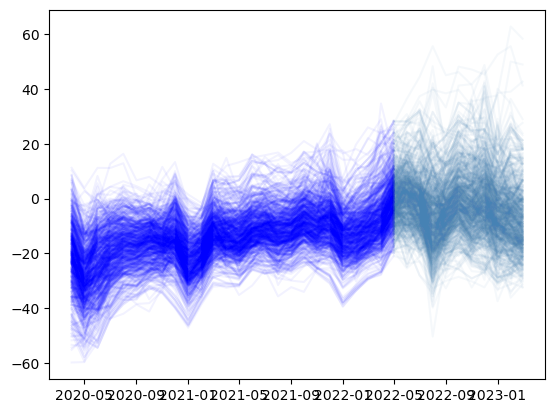

In [325]:
for i in range(len(fcst_admins)):
    fcst = fcst_admins[str(i)]
    plt.plot(fcst['ds'][:26], fcst['yhat'][:26], color='blue', alpha=0.05)
    plt.plot(fcst['ds'][25:], fcst['yhat'][25:], color='steelblue', alpha=0.05)